In [1]:
# Definitions, imports, etc.
import warnings


from pprint import pprint
from collections import OrderedDict as od

from astropy import units as u
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from poliastro.bodies import Sun, Earth, Saturn, Jupiter, Neptune, Uranus
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.plotting import StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.util import time_range, norm
from numpy import arccos


def magnitude(obj):
    return (norm(obj.rv()[0]).to(u.AU), norm(obj.rv()[1]))


def position(body, epoch):
    return (
        Ephem.from_body(body, epoch).rv()[0]
        if type(epoch) == Time
        else Ephem.from_body(body, Time(epoch)).rv()[0]
    )


def phasing_angle(body1, body2, epoch1, epoch2):
    # Angle of orbit deflections between body1 and body2
    pos1 = position(body1, epoch1)
    pos2 = position(body2, epoch2)
    x = (norm(pos1) ** 2 + norm(pos2 - pos1) ** 2 - norm(pos2) ** 2) / (
        2 * norm(pos1) * norm(pos2 - pos1)
    )
    return arccos(x).to(u.deg)


def angle(body1, body2, epoch1, epoch2):
    # Angle from sun between body1 and body2
    pos1 = position(body1, epoch1)
    pos2 = position(body2, epoch2)
    x = (norm(pos1) ** 2 + norm(pos2) ** 2 - norm(pos2 - pos1) ** 2) / (
        2 * norm(pos1) * norm(pos2)
    )
    return arccos(x).to(u.deg)


def jup_phase(launch):
    return angle(Jupiter, Uranus, launch + 2 * u.yr, launch + 9.5 * u.yr)


def loop():
    # Iterate over possible launch times, view angle between jupiter and uranus
    launch = Time("2024-01-01")
    for i in range(0, 20):
        l = launch + TimeDelta(i * u.yr)
        print(l, jup_phase(l))


def assist_to_planet(planet, arrival, current, color):
    planet_orbit = Ephem.from_body(
        planet,
        time_range(arrival - TimeDelta(1 * u.yr), end=arrival + TimeDelta(1 * u.yr)),
    )
    ss = Orbit.from_ephem(Sun, planet_orbit, arrival)
    man = Maneuver.lambert(current, ss)
    (flyby, _) = current.apply_maneuver(man, intermediate=True)
    flyby_end = flyby.propagate(arrival + TimeDelta(0 * u.wk))
    plotter.plot_body_orbit(planet, arrival, label=f"{planet} Time of Flyby")
    plotter.plot_trajectory(
        flyby_end.sample(min_anomaly=flyby.nu, max_anomaly=flyby_end.nu),
        label=f"To {planet}",
        color=color,
    )
    return (
        flyby_end,
        man.get_total_cost(),
    )


def run_mission(launch, planets):
    dates = od(
        {
            Earth: launch,
            Jupiter: launch + TimeDelta(2 * u.yr),
            Saturn: launch + TimeDelta(4 * u.yr),
            Uranus: launch + TimeDelta(9.5 * u.yr),
            Neptune: launch + TimeDelta(12 * u.yr),
        }
    )

    earth = Ephem.from_body(
        Earth, time_range(dates[Earth], end=dates[Earth] + TimeDelta(1 * u.yr))
    )
    ss_e = Orbit.from_ephem(Sun, earth, dates[Earth])
    init = Orbit.synchronous(Earth, epoch=dates[Earth]).change_attractor(
        Sun, force=True
    )
    plotter.plot_body_orbit(Earth, ss_e.epoch, label=f"{Earth} at end of flyby")

    ends = od({Earth: init.propagate(init.epoch + 12 * u.wk)})
    costs = od()

    for i in planets:
        ends[i], costs[i] = assist_to_planet(
            i, dates[i], list(ends.values())[-1], f"C{len(ends)}"
        )

    pprint(costs)
    pprint([f"{i}:{magnitude(v)}" for i, v in ends.items()])


solar_system_ephemeris.set("jpl")
warnings.filterwarnings("ignore")


OrderedDict([(Jupiter (♃), <Quantity 26.48372548 km / s>),
             (Uranus (⛢), <Quantity 19.04508459 km / s>)])
['Earth (♁):(<Quantity 0.83278872 AU>, <Quantity 32.95439608 km / s>)',
 'Jupiter (♃):(<Quantity 5.36520618 AU>, <Quantity 8.86637 km / s>)',
 'Uranus (⛢):(<Quantity 18.32641162 AU>, <Quantity 4.7060157 km / s>)']


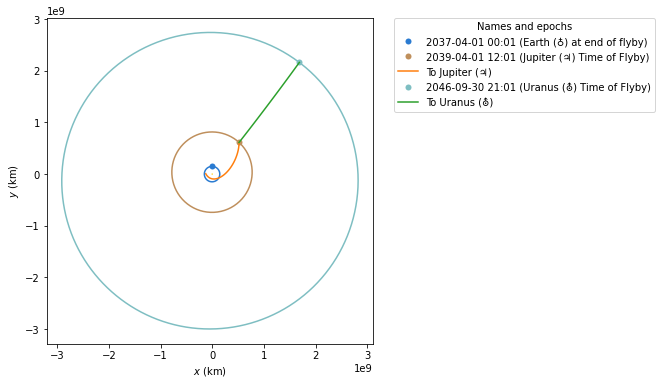

In [4]:
# Run mission
plotter = StaticOrbitPlotter()
launchdate = Time("2037-04-01", scale="utc").tdb
run_mission(launchdate, [Jupiter, Uranus])


OrderedDict([(Jupiter (♃), <Quantity 25.80256709 km / s>),
             (Saturn (♄), <Quantity 15.95696995 km / s>)])
['Earth (♁):(<Quantity 0.9416844 AU>, <Quantity 32.1024398 km / s>)',
 'Jupiter (♃):(<Quantity 5.43469777 AU>, <Quantity 10.1956297 km / s>)',
 'Saturn (♄):(<Quantity 9.88034512 AU>, <Quantity 8.95521598 km / s>)']


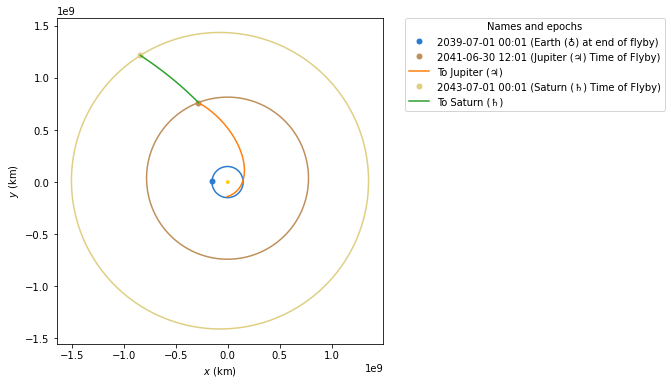

In [14]:
plotter = StaticOrbitPlotter()
launchdate = Time("2039-07-01", scale="utc").tdb
run_mission(launchdate, [Jupiter, Saturn])


OrderedDict([(Saturn (♄), <Quantity 21.40313459 km / s>),
             (Uranus (⛢), <Quantity 15.64565391 km / s>)])
['Earth (♁):(<Quantity 0.83475772 AU>, <Quantity 32.89821287 km / s>)',
 'Saturn (♄):(<Quantity 9.03771884 AU>, <Quantity 6.15086829 km / s>)',
 'Uranus (⛢):(<Quantity 18.59945636 AU>, <Quantity 6.30082048 km / s>)']


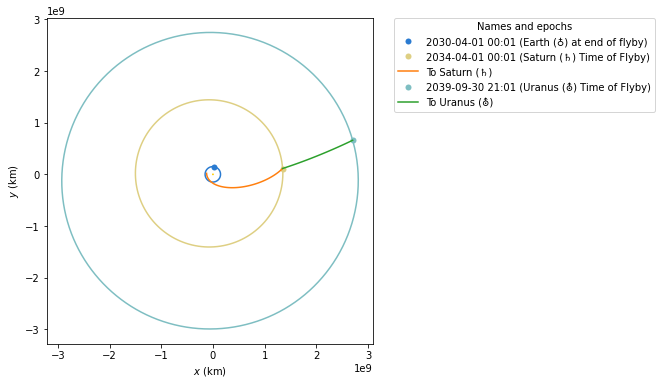

In [5]:
plotter = StaticOrbitPlotter()
launchdate = Time("2030-04-01", scale="utc").tdb
run_mission(launchdate, [Saturn, Uranus])
